In [258]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import Counter
from sklearn import metrics
from datetime import datetime
from utils.utils import *
from joblib import Parallel, delayed
from copy import deepcopy
import math


def return_important_vars(episode_presence,n_lag):
    if n_cluster==2:
        data_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check_2'.format(n_lag)
    elif n_cluster==6:
        data_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check_6'.format(n_lag)
    else:
        data_file = './data/episode_encoded_lagged_data/episode_encoded_'+'lagged_{}_windows_standardized_phenotype_with_episode_cluster_check'.format(n_lag)
    
    if episode_presence in [0,3]:
        if n_cluster==2:
            filename = './data/output_final/result_only_episode_lag_{}_triplet_loss_cluster_2.p'.format(n_lag)
        if n_cluster==6:
            filename = './data/output_final/result_only_episode_lag_{}_triplet_loss_cluster_6.p'.format(n_lag)
        else:
            filename = './data/output_final/result_only_episode_lag_{}_triplet_loss.p'.format(n_lag)
        
    elif episode_presence in [1]:
        # filename = './data/output_final/result_only_episode_lag_{}_triplet_loss_cluster_2.p'.format(n_lag)
        filename = './data/output_final/result_no_episode_lag_{}_triplet_loss.p'.format(n_lag)
    elif episode_presence in [2]:
        filename = './data/output_final/result_only_episode_lag_{}_triplet_loss_cluster_6.p'.format(n_lag)
        # result_with_episode_lag_{}_triplet_loss_v3.p'.format(n_lag)
    # else:
        # data_directory = './data/output/episode_encoded_lag_'
        # filename = data_directory+str(n_lag)+'_episode_model_v9_new_validation_set_include_smoking_focal_loss_static_coeff_phenotype_lower_model_no_episode_v3.p'
        
    data_eval = pickle.load(open(filename,'rb'))
    file1 = './data/mRisk/mRisk_Lapse_postquit.csv'
    puff_data = pd.read_csv(file1)
    data_feature_label = pickle.load(open(data_file,'rb'))
    data_cluster = pickle.load(open(data_file,'rb'))
    temp = data_cluster.groupby(['user','cluster_label']).count().index.values
    users = np.array([a[0] for a in temp])
    labels = np.array([a[1] for a in temp])
    cluster_dict = {}
    for i,a in enumerate(users):
        cluster_dict[a] = labels[i]
    y_time,y_pred,y_test,y_pid,bias_dict,val_results = data_eval[0],np.array(data_eval[1]),data_eval[2],data_eval[3],data_eval[4],data_eval[5]
    y_time,y_pred,y_test,y_pid,pars = np.array(y_time),np.array(y_pred).reshape(len(y_test),-1),np.array(y_test),np.array(y_pid),np.unique(y_pid)
    lapse_captured_dict = {}
    total_lapsers = 0
    result_phenotypes_final = {}
    return y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict

n_lag = 15
n_cluster = 2
label = 'DRES'
all_dfs = []
from sklearn.preprocessing import MinMaxScaler
for episode_presence in [0,1]:
    y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict = return_important_vars(episode_presence=episode_presence,n_lag=n_lag)
    if episode_presence==0:
        label = 'DDHI'
    else:
        label = 'DRES'
    y_pred_final = []
    for user in np.unique(y_pid):
        a = np.where(y_pid==user)[0]
        y_pred_pid = y_pred[a]
        biases = np.array(bias_dict[user])
        # if label=='DRES':
            # y_pred_pid = MinMaxScaler().fit_transform(y_pred_pid)
        for ii in range(y_pred_pid.shape[1]):
            y_pred_pid[:,ii] = np.array(y_pred_pid[:,ii]>=np.percentile(y_pred_pid[:,ii],80),dtype=int)
        y_pred_pid = np.mean(y_pred_pid,axis=1) 
        y_pred_final.extend(list(y_pred_pid))
    df = pd.DataFrame({'Original':y_test,'Predicted':y_pred_final,'User':y_pid,'Time':y_time})
    df['Model'] = [label]*df.shape[0]
    all_dfs.append(df)

df_final = pd.concat(all_dfs)
def get_lapse_times(puff_data,par):
    return np.array([np.datetime64(datetime.fromtimestamp(lapse_time/1000)) for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values])


def get_positive_only_prediction(df):
    df = df.sort_values('Time').reset_index(drop=True)
    lapse_times = get_lapse_times(puff_data,df['User'].values[0])
    if len(lapse_times)==0:
        return pd.DataFrame([],columns=df.columns)
    df['Lapse'] = [-1]*df.shape[0]
    indexes = []
    for i,row in df.iterrows():
        for j,lapse in enumerate(lapse_times):
            if row['Time']<=lapse and abs((row['Time']-lapse).total_seconds()/60)<=60:
                indexes.append(i)
                df['Lapse'].at[i] = j
    return df.loc[indexes]

df_all_final = df_final.groupby(['User','Model'],as_index=False).apply(get_positive_only_prediction)

final_df = []
for bias in np.arange(.2,1,.01):
    def get_results(df):
        # if df.shape[0]<5:
        #     return pd.DataFrame([],columns=['y_test','y_pred','user','Model'])
        model_name = df['Model'].values[0]
        user = df['User'].values[0]
        if np.max(df['Predicted'])>=bias:
            y_pred = 1
        else:
            y_pred = 0
        return pd.DataFrame({'y_test':[1],'y_pred':[y_pred],'user':[user],'Model':[model_name]})

    results = df_all_final.groupby(['User','Model','Lapse'],as_index=False).apply(get_results).reset_index(drop=True)
    from sklearn.metrics import accuracy_score
    results_scores = results.groupby('Model',as_index=False).apply(lambda a:pd.Series({'Accuracy':accuracy_score(a['y_test'],a['y_pred'])}))
    results_scores['Bias'] = bias
    final_df.append(results_scores)

In [259]:
final_df_result = pd.concat(final_df)

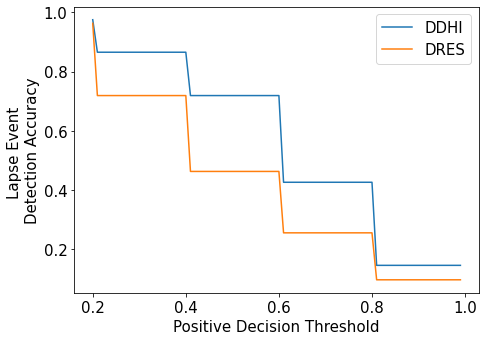

In [260]:
plt.figure(figsize=(7,5))
sns.lineplot(x='Bias',y='Accuracy',hue='Model',data=final_df_result[final_df_result.Model!='DHI'])
plt.legend()
plt.xlabel('Positive Decision Threshold')
plt.ylabel('Lapse Event \nDetection Accuracy')
plt.tight_layout()
plt.savefig('./data/images/detection_accuracy.png')
plt.show()

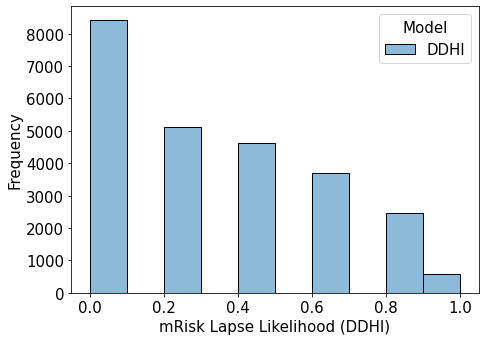

In [262]:
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(7,5))
sns.histplot(x='Predicted',hue='Model',data=df_final[df_final.Model=='DDHI'],bins=10)
plt.xlabel('mRisk Lapse Likelihood (DDHI)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./data/images/histogram_of_risk_likelihood.png')
plt.show()

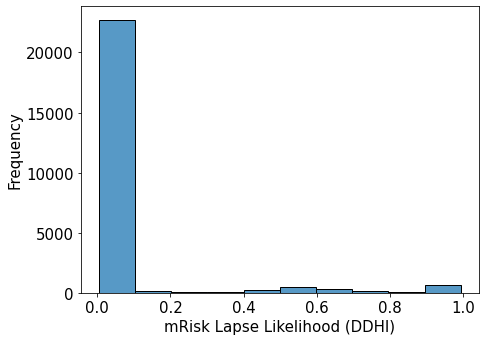

In [101]:
import seaborn as sns
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(7,5))
sns.histplot(y_pred_final,bins=10)
plt.xlabel('mRisk Lapse Likelihood (DDHI)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./data/images/histogram_of_risk_likelihood.png')
plt.show()

In [112]:
df.loc[df.shape[0]-1]

Original             1
Predicted    0.0150608
User              3168
Model             DRES
Name: 24925, dtype: object

In [114]:
df[-1:]

,Original,Predicted,User,Model
24925,1.0,0.015061,3168,DRES
